In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf

Using TensorFlow backend.


In [2]:
df = pd.read_csv('IBM_2006-01-01_to_2018-01-01.csv', parse_dates=['Date'])

In [11]:
df

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
1,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
3,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
4,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM
...,...,...,...,...,...,...,...
3015,2017-12-22,151.82,153.00,151.50,152.50,2990583,IBM
3016,2017-12-26,152.51,153.86,152.50,152.83,2479017,IBM
3017,2017-12-27,152.95,153.18,152.61,153.13,2149257,IBM
3018,2017-12-28,153.20,154.12,153.20,154.04,2687624,IBM


In [12]:
df.index = df.Date
df.drop(['Date'], axis=1, inplace=True)

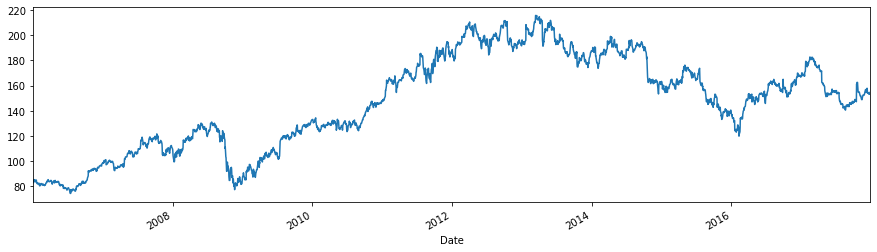

In [13]:
fig = plt.figure(figsize=(15, 4))
df.High.plot()

Разделение выборки на обучающую и тестовую

In [14]:
training_set = df[:'2016'].iloc[:, 1:2].values
test_set = df['2017':].iloc[:, 1:2].values

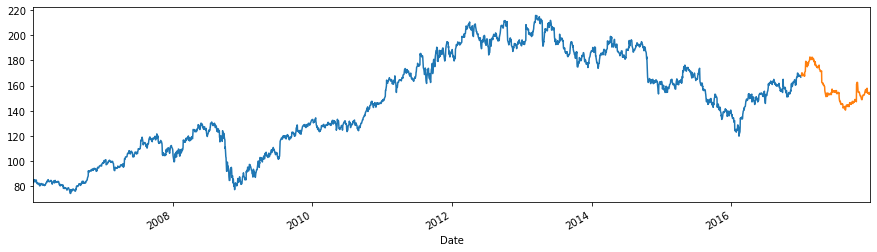

In [16]:
fig = plt.figure(figsize=(15, 4))
df.High[:'2016'].plot()
df.High['2017':].plot()

Автокорреляция

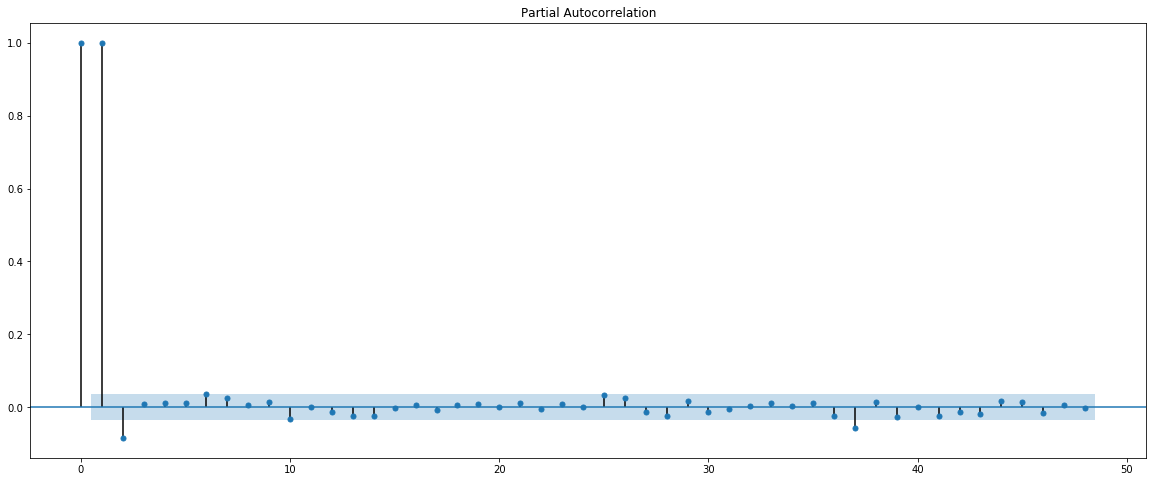

In [17]:
fig, ax = plt.subplots(figsize=(20, 8))
sm.graphics.tsa.plot_pacf(df.High.values, lags=48, ax=ax)
plt.show()

Нормируем данные

In [18]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

Строим признаки на снове сдвигов

In [19]:
shift_size = 30

X_train = []
y_train = []
for i in range(shift_size, len(training_set)):
    X_train.append(training_set_scaled[i-shift_size:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

Регрессор на базе градиентного бустинга

In [20]:
boost_regressor = XGBRegressor()
boost_regressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

Подготовка тестовых данных

In [21]:
dataset_total = pd.concat((df.High[:'2016'], df.High['2017':]), axis=0)
inputs = dataset_total[len(dataset_total) - len(test_set) - shift_size:].values
inputs = inputs.reshape(-1, 1)
inputs  = sc.transform(inputs)

In [22]:
X_test = []
for i in range(shift_size, len(test_set) + shift_size):
    X_test.append(inputs[i - shift_size:i, 0])
X_test = np.array(X_test)

In [23]:
boost_pred = boost_regressor.predict(X_test)
boost_pred = sc.inverse_transform(boost_pred[:, np.newaxis])

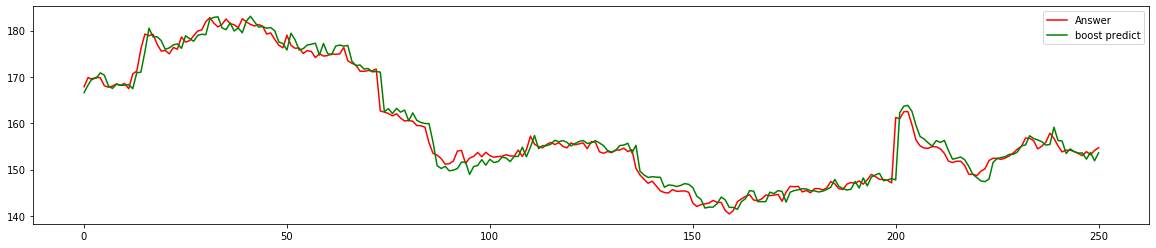

In [27]:
fig, axes = plt.subplots(1, figsize=(20, 4))
axes.plot(test_set, color='red')
axes.plot(boost_pred, color='green')
axes.legend(['Answer', 'boost predict'])

Регрессор на основе случайного леса

In [28]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [29]:
rf_pred = rf_regressor.predict(X_test)
rf_pred = sc.inverse_transform(rf_pred[:, np.newaxis])

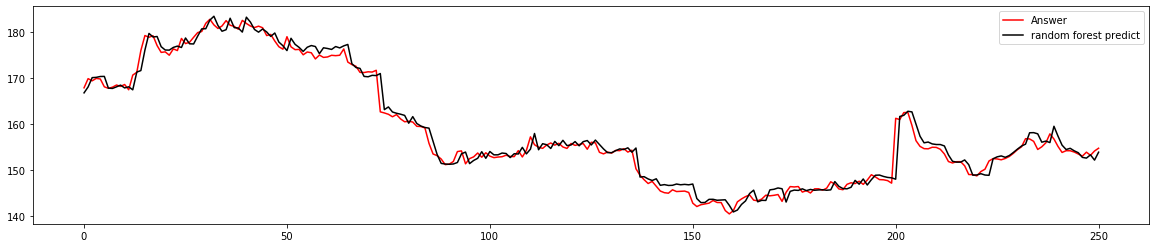

In [30]:
fig, axes = plt.subplots(1, figsize=(20, 4))
axes.plot(test_set, color='red')
axes.plot(rf_pred, color='black')
axes.legend(['Answer', 'random forest predict'])

Простое экспоненциальное сглаживание

In [31]:
def exp_smoothing(train, test):
    forecast = []
    for i in range(len(test)):
        training_set = np.concatenate((train, test[:i]))
        fit = SimpleExpSmoothing(training_set).fit(smoothing_level=0.7, optimized=False)
        forecast.append(fit.forecast(1))
        
    return np.array(forecast)


In [32]:
exp_pred = exp_smoothing(training_set, test_set)

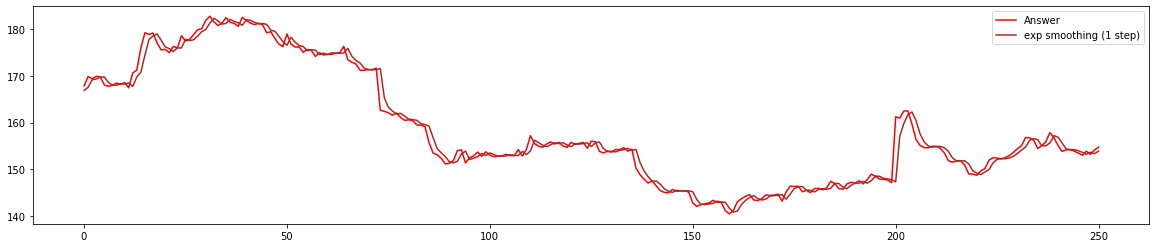

In [33]:
fig, axes = plt.subplots(1, figsize=(20, 4))
axes.plot(test_set, color='red')
axes.plot(exp_pred, color='brown')
axes.legend(['Answer', 'exp smoothing (1 step)'])

Преобразуем тестовые данные для входа нейросети (добавим размерность)

In [34]:
X_train = X_train[..., np.newaxis]

In [35]:
X_train.shape

(2739, 30, 1)

Построим модель из одного LSTM слоя с 500 нейронами и dropout с вероятностью 0.2 в качестве регуляризации нашей модели. <BR>Оптимизатор - **Adam**, лосс функция - **MSE**. 
<BR>Обучать будем 50 эпох, размер батча - 32

In [37]:
regressor = Sequential()

regressor.add(LSTM(units=500, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))


regressor.add(Dense(units=1))

regressor.compile(optimizer='adam', loss='mean_squared_error')

regressor.fit(X_train, y_train, epochs=50, batch_size=32, workers=3, validation_data=[X_test[..., np.newaxis], test_set])

Train on 2739 samples, validate on 251 samples
Epoch 1/50
2739/2739 [==============================] - 27s 10ms/step - loss: 0.0174 - val_loss: 25086.0343
Epoch 2/50
2739/2739 [==============================] - 25s 9ms/step - loss: 9.2117e-04 - val_loss: 25088.6557
Epoch 3/50
2739/2739 [==============================] - 26s 9ms/step - loss: 8.9689e-04 - val_loss: 25086.0962
Epoch 4/50
2739/2739 [==============================] - 27s 10ms/step - loss: 8.2410e-04 - val_loss: 25086.0566
Epoch 5/50
2739/2739 [==============================] - 26s 9ms/step - loss: 8.2829e-04 - val_loss: 25086.4674
Epoch 6/50
2739/2739 [==============================] - 27s 10ms/step - loss: 7.4531e-04 - val_loss: 25085.2890
Epoch 7/50
2739/2739 [==============================] - 27s 10ms/step - loss: 7.5532e-04 - val_loss: 25086.0631
Epoch 8/50
2739/2739 [==============================] - 25s 9ms/step - loss: 7.7046e-04 - val_loss: 25083.0633
Epoch 9/50
2739/2739 [==============================] - 28s 10ms/

KeyboardInterrupt: 

In [72]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
lstm_pred = regressor.predict(X_test)
lstm_pred = sc.inverse_transform(lstm_pred)

Отрисуем все предсказания на графике

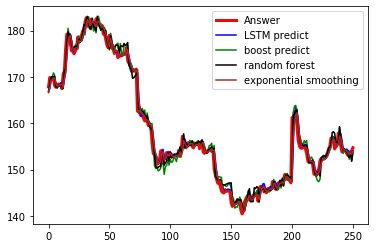

In [90]:
fig, axes = plt.subplots(1)
axes.plot(test_set, color='red', linewidth=3)
axes.plot(lstm_pred, color='blue')
axes.plot(boost_pred, color='green')
axes.plot(rf_pred, color='black')
axes.plot(exp_pred, color='brown')
axes.legend(['Answer', 'LSTM predict', 'boost predict', 'random forest', 'exponential smoothing'])

Посчитаем метрику MAPE для всех наших методов

In [92]:
import inspect

def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var][0]

def MAPE(y_true, y_pred):
    return (np.abs(y_true - y_pred) / y_true).sum() / y_true.shape[0] * 100

for predict in [boost_pred, rf_pred, exp_pred, lstm_pred]:
    print("{}: MAPE = {:.2}%".format(retrieve_name(predict), MAPE(test_set, predict)))

boost_pred: MAPE = 0.81%
rf_pred: MAPE = 0.72%
exp_pred: MAPE = 0.63%
lstm_pred: MAPE = 0.68%
